## Aircraft wildlife strike data analysis

### **Context**

Wildlife strikes have posed a significant threat to the aviation industry since its inception. Though wildlife may seem rather harmless due to their small size relative to that of aircrafts, Newton's laws of physics state that depending on the aircraft's size and the airspeed during impact, these collisions can be highly devastating. Notable wildlife strike incidents in aviation history include the emergency landing of US Airways Flight 1549 (Sully), where the Airbus A320 suffered double engine failure after striking a flock of birds (fortunately, there were no fatalities), and the more recent tragic Jeju Air crash, where 179 passengers lost their lives following a similar incident. 

Given the potential for severe damage to aircrafts, understanding the factors contributing to cost of repair and maintenance is crucial for the aviation industry. Thus, this project aims to build a model that predicts the cost of repairs and/or replacement in USD, which can be very helpful for companies to develop strategies to mitigate these costs. To accurately understand the costs associated with repairs and maintenance, wildlife strike data was obtained from the Federal Aviation Administration, which spans from 1990 to 2024.

Link to data: https://wildlife.faa.gov/search

#### Loading all the necessary libraries 

In [2]:
import datetime
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', None)

Matplotlib is building the font cache; this may take a moment.


#### Loading the data

In [3]:
cols_to_keep = ['INCIDENT_MONTH', 'TIME','TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'AIRCRAFT', 'EMA', 'AC_CLASS', 'AC_MASS', 'TYPE_ENG', 'NUM_ENGS', 'SPEED', 'PHASE_OF_FLIGHT', 'DAMAGE_LEVEL', 'DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'ING_ENG1', 'DAM_ENG2', 'ING_ENG2', 'DAM_ENG3', 'ING_ENG3', 'DAM_ENG4', 'ING_ENG4', 'INGESTED_OTHER', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER', 'NUM_STRUCK', 'SIZE', 'COST_REPAIRS_INFL_ADJ']

def load_data(keep_cols=None):
    """
    Load data from a specified Excel file.
    Args:
        keep_cols (list, optional): List of column names to keep from the loaded DataFrame.
    Returns:
        pd.DataFrame: The loaded DataFrame or None if an error occurs.
    """
    file_path = input("Enter the path to your Excel file: ")  # Prompt for file path
    try:
        data = pd.read_excel(file_path)
        print("Data successfully loaded.")
        if keep_cols:
            data = data[keep_cols]
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data(keep_cols=cols_to_keep)
df_copy = df.copy()

Data successfully loaded.


Variables considered:
1. Time/time of day
- Time of day affects availability of resources, severity of strike, airport operations, and may also coincide with specific weather conditions, which affect repair needs. 
2. Aircraft/ aircraft type & mass
- Laws of physics state that the higher the mass of an object, the greater the impact on collision with another object/ living thing. This has a direct implication of the extent of damage on the aircraft, and the cost of repair.
3. Size & number of wildlife struck
- Both factors combined directly impacts the level of damage and costs of repair. A small wildlife by itself might not be as significiant as a small wildlife in flock. 
4. Speed of aircraft
- Laws of physics. Larger the momentum, greater the impact, and thus repair. At the same phase of flight, airplanes are most likely to have similar speeds. Thus, missing speed values will be imputed using the corresponding median speeds for each phase of flight.
5. Damage & costs to aircraft
- Damages are the reason for cost and thus most definitely need to be retained for analysis.
6. Type of engine
- Engine repairs typically take up the bulk of repair costs. Thus, it is essential to retain this variable as it can affect how expensive the repairs might be.
7. Airport location
- Affects the species of birds (and therefore their size) in the vicinity and their migration patterns, which affects the strikes and therefore cost of repairs.

#### Inspect data

In [45]:
df_copy.head()

,INCIDENT_MONTH,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,AIRCRAFT,EMA,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SPEED,PHASE_OF_FLIGHT,DAMAGE_LEVEL,DAM_RAD,DAM_WINDSHLD,DAM_NOSE,DAM_ENG1,ING_ENG1,DAM_ENG2,ING_ENG2,DAM_ENG3,ING_ENG3,DAM_ENG4,ING_ENG4,INGESTED_OTHER,DAM_PROP,DAM_WING_ROT,DAM_FUSE,DAM_LG,DAM_TAIL,DAM_LGHTS,DAM_OTHER,NUM_STRUCK,SIZE,COST_REPAIRS_INFL_ADJ
0,9,19:50,Dusk,KORD,41.97960,-87.90446,B-777-300,22.0,A,5.0,D,2.0,NaN,Take-off Run,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,365000.0
1,3,NaN,None,KCVG,39.04614,-84.66217,B-737-800,10.0,A,4.0,D,2.0,155.0,Approach,N,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,11-100,Small,71000.0
2,7,19:15,Day,KAUS,30.19453,-97.66987,B-737-8,10.0,A,4.0,D,2.0,140.0,Landing Roll,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,1000.0
3,9,21:30,Night,KUNV,40.84928,-77.84869,EMB-170,22.0,A,4.0,D,2.0,NaN,Approach,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,630.0
4,7,NaN,None,KLGA,40.77724,-73.87261,A-320,23.0,A,4.0,D,2.0,NaN,Climb,M,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,1,Medium,NaN


#### Cleaning the data

In [5]:
def process_time_of_day(data, time_col='TIME', month_col='INCIDENT_MONTH'):
    """
    Process the time of day based on the time and incident month, and clean the dataset.
    Args:
        data (pd.DataFrame): The input DataFrame.
        time_col (str): The column name for time (format '%H:%M').
        month_col (str): The column name for incident month. 
    Returns:
        pd.DataFrame: The processed DataFrame with a new 'TIME_OF_DAY' column and cleaned data.
    """
    def assign_time_of_day(row):
        time = row[time_col]
        month = row[month_col]
        # Check if TIME is missing or invalid
        if pd.isna(time):
            return None  # Skip if TIME is missing
        # Convert TIME to datetime if not already
        time = str(time).strip()
        try:
            time = pd.to_datetime(time, errors='raise').time()
        except Exception:
            return None  # Return None for invalid time formats

        # Define time ranges for different seasons
        seasons = {
            'summer': [5, 6, 7, 8],    # Summer months
            'winter': [11, 12, 1, 2],  # Winter months
            'transitional': [3, 4, 9, 10]  # Transitional months
        }

        # Determine the season based on the month
        season = 'transitional'  # Default season is transitional
        for s, months in seasons.items():
            if month in months:
                season = s
                break

        # Define time-of-day ranges for each season
        time_ranges = {
            'summer': {
                'Dawn': (datetime.time(4, 0), datetime.time(6, 0)),
                'Day': (datetime.time(6, 0), datetime.time(20, 0)),
                'Dusk': (datetime.time(20, 0), datetime.time(21, 30)),
                'Night': (datetime.time(21, 30), datetime.time(4, 0))
            },
            'winter': {
                'Dawn': (datetime.time(6, 0), datetime.time(7, 30)),
                'Day': (datetime.time(7, 30), datetime.time(17, 30)),
                'Dusk': (datetime.time(17, 30), datetime.time(18, 30)),
                'Night': (datetime.time(18, 30), datetime.time(6, 0))
            },
            'transitional': {
                'Dawn': (datetime.time(5, 0), datetime.time(7, 0)),
                'Day': (datetime.time(7, 0), datetime.time(19, 0)),
                'Dusk': (datetime.time(19, 0), datetime.time(20, 30)),
                'Night': (datetime.time(20, 30), datetime.time(5, 0))
            }
        }

        # Identify the time of day based on the season and time range
        for period, (start_time, end_time) in time_ranges[season].items():
            if start_time <= time < end_time:
                return period
        return 'Night'  # Default to 'Night' if no match

    # Apply the function to assign time of day
    data['TIME_OF_DAY'] = data.apply(assign_time_of_day, axis=1)

    # Drop rows where 'TIME_OF_DAY' couldn't be assigned but 'time_col' is not missing
    missing_time_of_day = data[data['TIME_OF_DAY'].isna() & data[time_col].notna()]
    print(f'Number of entries without "TIME_OF_DAY" filled in: {missing_time_of_day.shape[0]}')

    # Drop the 'time_col' column and rows without 'TIME_OF_DAY'
    data = data.drop(columns=[time_col])
    data = data.dropna(subset=['TIME_OF_DAY'])

    return data

In [6]:
def aircraft_mass(df): 
    """
    Clean the dataset based on the aircraft type, aircraft name (family) and the mass
    Args:
        data (pd.DataFrame): The input DataFrame.
    """

    # Filter out rows with missing 'AC_CLASS' values
    df = df[~df['AC_CLASS'].isna()]
    # Filter for aircraft class 'A' corresponding to airplanes
    df = df[df['AC_CLASS'] == 'A']
    # Drop AC_CLASS column
    df.drop('AC_CLASS', axis=1, inplace=True)
    # Set AC_MASS to category 4 for 'AC-130' aircraft
    df.loc[df['AIRCRAFT'] == 'AC-130', 'AC_MASS'] = 4
    # Drop rows with missing AC_MASS
    df.dropna(subset=['AC_MASS'], inplace=True)
    # Map aircraft mass categories to specified ranges defined in metadata
    mass_mapping = {
        '1.0': '2250 or less',
        '2.0': '2251-5700',
        '3.0': '5701-27000',
        '4.0': '27001-272000',
        '5.0': '272001 or more'
    }
    # Convert 'AC_MASS' to string and map to mass categories
    df['AC_MASS'] = df['AC_MASS'].astype(str).map(mass_mapping)

    # Inner function to extract aircraft family using regex
    def extract_air_family(name):
        matched = re.search(r'([A-Za-z0-9]+-[A-Za-z0-9]+)', name)
        if matched:
            return matched.group(0)
        else:
            return name
    
    # Apply the regex to standardise the name then drop the original aircraft col
    df['AIRCRAFT_FAMILY'] = df['AIRCRAFT'].apply(extract_air_family)
    df = df.drop('AIRCRAFT', axis=1)
    # Calculate proportion of aircraft families
    prop = df['AIRCRAFT_FAMILY'].value_counts(normalize=True).sort_values(ascending=False).cumsum()
    # Filter aircrafts contributing to top 95% of total
    top_95 = prop[prop <= 0.95].index
    # Create new column to regroup aircraft families
    df['AIRCRAFT_FAMILY_GROUPED'] = df['AIRCRAFT_FAMILY'].apply(lambda x: x if x in top_95 else 'Others')
    return df

In [7]:
def bird(df): 
    """
    Remove rows with missing values in 'NUM_STRUCK' AND 'SIZE' columns.
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop rows with missing values in 'NUM_STRUCK' and 'SIZE' columns
    df = df[~(df['NUM_STRUCK'].isna() | df['SIZE'].isna())]
    return df

In [8]:
def phase_speed(df):
    """
    Fill in rows with missing speed values with the median speeds for aircrafts within the same phase of flight
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop rows with unknown phase of flight
    df = df[df['PHASE_OF_FLIGHT'] != 'Unknown']
    # Calculate the median SPEED for each PHASE_OF_FLIGHT
    phase_medians = df.groupby('PHASE_OF_FLIGHT')['SPEED'].median()
    # Fill missing SPEED values with the corresponding median values
    df['SPEED'] = df['SPEED'].fillna(
        df['PHASE_OF_FLIGHT'].map(phase_medians)
    )
    # Drop the remaining entries with missing speed and drop phase of flight col
    df = df.dropna(subset=['SPEED'])
    df = df.drop('PHASE_OF_FLIGHT', axis=1)
    return df

In [ ]:
damage_components = ['DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER']
ingestion = ['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4', 'INGESTED_OTHER']

def damage_cost(df):
    """
    Remove invalid costs using damage as the reference, fill in missing values for damage cols, and log transformation to cost
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # First deal with damages and the associated cost
    # Fill in damage level with N if all damage components are false
    df.loc[df[damage_components].sum(axis=1) == 0, 'DAMAGE_LEVEL'] = 'N'
    # Extract rows with all damage components = False to investigate cost col
    no_damage = df[~df[damage_components].any(axis=1)]
    # Fill 0 in rows with NA repair costs where entries correspond to those with no damage
    df['COST_REPAIRS_INFL_ADJ'] = df.apply(
        lambda row: 0 if row.name in no_damage.index and pd.isna(row['COST_REPAIRS_INFL_ADJ']) else row['COST_REPAIRS_INFL_ADJ'],
        axis=1
    )
    # Fill in 0 in cost where damage level is N if cost is na
    df.loc[
        df['COST_REPAIRS_INFL_ADJ'].isna() &
        df['DAMAGE_LEVEL'].isin(['0', 'N']),
        'COST_REPAIRS_INFL_ADJ'] = 0
    # Set up condition that defines all ingestion and damage components are False but cost > 0
    condition = (
        (df[ingestion].sum(axis=1) == 0) &
        (df[damage_components].sum(axis=1) == 0) &
        (df['COST_REPAIRS_INFL_ADJ'] > 0)
    )
    # Remove rows that satisfy the condition
    df = df[~condition]
    # Damage mapping dictionary according to metadata
    damage_map = {
        'N': 'None',
        'M': 'Minor',
        'M?': 'Undetermined',
        'S': 'Substantial',
        'D': 'Destroyed'
    }
    # Now map over relevant names to the damage column
    df['DAMAGE_LEVEL'] = df['DAMAGE_LEVEL'].map(damage_map)

    # Now deal with costs alone
    df = df[df['COST_REPAIRS_INFL_ADJ']>=0]
    df = df.dropna(subset=['COST_REPAIRS_INFL_ADJ'])
    # Apply log1p transformation due to skewness of data
    df['log1p_COST_REPAIRS_INFL_ADJ'] = np.log1p(df['COST_REPAIRS_INFL_ADJ'])
    return df

In [10]:
def manfacturer_eng(df):
    # Engine manufacturers mapping based on dictionary codes
    engin_manu_map = {
        '1': 'Allison',
        '2': 'Allied Signal',
        '4': 'Alvis',
        '7': 'Avo Lycoming',
        '8': 'Bristol',
        '9': 'BMW/RR',
        '10': 'CFM International',
        '11': 'CFE Company',
        '13': 'Continental',
        '16': 'Curtiss-Wright',
        '19': 'Garret Airesearch',
        '22': 'General Electric',
        '23': "Int'l Aero Engines",
        '24': 'Isotov',
        '25': 'Ivchenko',
        '27': 'Klimov',
        '28': 'Lotarev',
        '2A': 'Motorlet',
        '30': 'Porsche',
        '31': 'Pratt & Whitney (CA)',
        '34': 'Praat & Whitney (USA)',
        '36': 'PZL',
        '37': 'Rolls Royce',
        '40': 'Soliev',
        '43': 'Turbomeca',
        '46': 'Williams',
        '49': 'ZMKB Progress',
        'Y0': 'Military',
        'Z': 'Unknown'
    }
    # Attempt to fill in missing ema value for each aircraft family
    # Find the most common EMA for each unique AIRCRAFT_FAMILY
    most_common_ema = df.groupby('AIRCRAFT_FAMILY')['EMA'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    # Only map the EMA values where there is a valid 'most_common_ema'
    # First, create a mapping using the most_common_ema, ensuring missing EMA values are not mapped
    mapping = most_common_ema.dropna()  # Remove any 'None' or missing values from the mapping
    # Fill in the missing EMA values using the mapping, but only where the mapping exists
    df['EMA'] = df['EMA'].fillna(df['AIRCRAFT_FAMILY'].map(mapping))
    # Drop all rows with missing ema values even after filling
    df.dropna(subset=['EMA'], inplace=True)
    # Convert ema to string type for mapping
    df['EMA'] = df['EMA'].apply(lambda x: str(x).replace('.0', ''))
    # Then map the manufacturer names and drop original EMA and aircraft family col
    df['ENGIN_MANUFACTURER'] = df['EMA'].apply(lambda x: engin_manu_map.get(x, 'Others'))
    df.drop(columns=['EMA', 'AIRCRAFT_FAMILY'], inplace=True)
    return df

In [11]:
def engines(df):
    """
    Map the type of engines over to their respective names, and to feature engineer 2 additional cols: number of ingested/ damaged engines while ensuring data integrity
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop missing values
    df = df.dropna(subset=['TYPE_ENG'])
    # Create a dictionary for engine type mapping
    engine_map = {
        'A': 'Piston',
        'B': 'Turbojet',
        'C': 'Turboprop',
        'D': 'Turbofan'
    }
    # Replace the values in the 'TYPE_ENG' column using the mapping
    df['TYPE_ENG'] = df['TYPE_ENG'].replace(engine_map)
    # Calculate the number of affected engines for each incident by summing the boolean values for each engine damage column
    df['NUM_DAM_ENGINES'] = (df[['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4']].sum(axis=1))
    df['NUM_ING_ENGINES'] = (df[['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4']].sum(axis=1))
    # Drop rows with invalid data
    df = df[(df['NUM_ING_ENGINES'] <= df['NUM_ENGS']) & (df['NUM_DAM_ENGINES'] <= df['NUM_ENGS'])]
    # Remove original dam and ingested cols
    df = df.drop(columns=['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4', 'ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4', 'NUM_ENGS'])
    
    # Create interaction term between damaged and ingested engines
    df['ENGINES_INTERACTION'] = df['NUM_DAM_ENGINES'] * df['NUM_ING_ENGINES']
    return df

Based on the dataset information, the number of engines present in each aircraft is available. This value needs to be at least or greater than the total number of engines that were damaged/ingested. Entries with discrepancies will need to be dropped. In addition, in place of keeping the individual damaged and ingested columns, it may be more insightful to calculate the total number of damaged/ingested engines as these values will be more relevant to the actual repair costs.

Aside from simply the engineered variable on the number of damaged/ingested engines, there may be a potential interaction between the variables pertaining to engines (ingested and damaged engines) as they both can contribute to repair costs. Thus, an additional interaction term is calculated and included in the dataset for analysis.

In [12]:
def location(df):
    # Extract unique latitude and longitude for each AIRPORT_ID
    airport_coords = df[['AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']].dropna().drop_duplicates()
    # Map the latitudes and longitudes to the rows with missing values
    df['AIRPORT_LATITUDE'] = df['AIRPORT_LATITUDE'].fillna(df['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LATITUDE']))
    df['AIRPORT_LONGITUDE'] = df['AIRPORT_LONGITUDE'].fillna(df['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LONGITUDE']))

    # Filter out rows with invalid coordinates
    df = df[
        (df['AIRPORT_LATITUDE'] >= -90) & 
        (df['AIRPORT_LATITUDE'] <= 90) &
        (df['AIRPORT_LONGITUDE'] >= -180) & 
        (df['AIRPORT_LONGITUDE'] <= 180)]
    return df

In [ ]:
def initial_preprocess(df):
    """
    Overall code to clean the entire dataset
    """
    df = process_time_of_day(df, time_col='TIME', month_col='INCIDENT_MONTH') # First step of cleaning: time processing
    df = aircraft_mass(df) # 2nd part of cleaning: aircraft and mass cleaning
    df = bird(df) # 3rd part of cleaning: removing entries without wildlife info
    df = phase_speed(df) # 4th part of cleaning: inputting speed values using phase of flight
    df = damage_cost(df) # 5th part of cleaning: managing the missing values for damage level and costs
    df = manfacturer_eng(df) # 6th part of cleaning: managing the values of engine manufacturer
    df = engines(df) # 7th part of cleaning: managing the values of engine type
    df = location(df) # 8th part: to remove invalid locations
    return df

data = initial_preprocess(df_copy)
data.info()

Number of entries without "TIME_OF_DAY" filled in: 0


/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_53648/3254423867.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPEED'] = df['SPEED'].fillna(
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_53648/3637249472.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DAMAGE_LEVEL'] = df['DAMAGE_LEVEL'].map(damage_map)


<class 'pandas.core.frame.DataFrame'>
Index: 107764 entries, 59 to 310726
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   INCIDENT_MONTH               107764 non-null  int64  
 1   TIME_OF_DAY                  107764 non-null  object 
 2   AIRPORT_ID                   107764 non-null  object 
 3   AIRPORT_LATITUDE             107764 non-null  float64
 4   AIRPORT_LONGITUDE            107764 non-null  float64
 5   AC_MASS                      107764 non-null  object 
 6   TYPE_ENG                     107764 non-null  object 
 7   SPEED                        107764 non-null  float64
 8   DAMAGE_LEVEL                 107764 non-null  object 
 9   DAM_RAD                      107764 non-null  bool   
 10  DAM_WINDSHLD                 107764 non-null  bool   
 11  DAM_NOSE                     107764 non-null  bool   
 12  INGESTED_OTHER               107764 non-null  bool   
 13  DAM

/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_53648/1575144288.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TYPE_ENG'] = df['TYPE_ENG'].replace(engine_map)
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_53648/1575144288.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NUM_DAM_ENGINES'] = (df[['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4']].sum(axis=1))
/var/folders/vp/y17z3kl153g6yzxs84v9wh080000gn/T/ipykernel_53648/1575144288.py:20: SettingWithCopyWarning: 
A v

#### Exploratory data
Geographical map was plotted to observe for any potential patterns in wildlife strike across the US and other international locations. This analysis is valuable for route planning, as it helps identify regions with higher incidences of wildlife strikes. By integrating such data into flight planning, airlines can adjust flight paths to minimize the risk of encountering wildlife, thereby enhancing safety.

In [14]:
def strike_geogmap(df):
    """
    Function to generate and display a heatmap of aircraft wildlife strikes.
    The input DataFrame should have the cleaned columns 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', and 'STRIKE_COUNT'.
    
    Args:
    - df (DataFrame): Data with 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', and 'STRIKE_COUNT' columns.
    
    Returns:
    - folium.Map: The map object with heatmap visualization.
    """
    strike_counts = df.groupby(['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']).size().reset_index(name='STRIKE_COUNT')

    # Initialize a map, centered at an average location
    map_center = [strike_counts['AIRPORT_LATITUDE'].mean(), df['AIRPORT_LONGITUDE'].mean()]
    wildlife_map = folium.Map(location=map_center, zoom_start=5)

    # Prepare the data for the heatmap
    heat_data = strike_counts[['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'STRIKE_COUNT']].values.tolist()
    HeatMap(heat_data, radius=10).add_to(wildlife_map)

    # Add title to the map
    title_html = '''
                 <h3 align="center" style="font-size: 20px; font-weight: bold;">Aircraft Wildlife Strike Locations</h3>
                 '''
    wildlife_map.get_root().html.add_child(folium.Element(title_html))

    # Add a custom legend using HTML and CSS
    legend_html = """
    <div style="position: fixed; 
                bottom: 30px; left: 30px; width: 250px; height: 150px; 
                background-color: white; border:2px solid grey; z-index:9999;
                font-size: 14px; padding: 15px;">
        <strong>Strike Intensity</strong><br>
        <i style="background-color:blue; width: 20px; height: 20px; display: inline-block;"></i> Low<br>
        <i style="background-color:green; width: 20px; height: 20px; display: inline-block;"></i> Moderate<br>
        <i style="background-color:yellow; width: 20px; height: 20px; display: inline-block;"></i> High<br>
        <i style="background-color:red; width: 20px; height: 20px; display: inline-block;"></i> Very High
    </div>
    """

    # Attach the legend to the map
    wildlife_map.get_root().html.add_child(folium.Element(legend_html))

    return wildlife_map

strike_geogmap(data)

There appears to be a significantly higher occurrence of wildlife strikes around New York compared to other parts of the USA. This pattern is reminiscent of the Sully flight incident, where the plane encountered a bird strike shortly after takeoff, but fortunately, the pilots were able to safely land the aircraft on the Hudson River. The higher frequency of wildlife strikes in this region may point to bird migratory patterns, but it could also be attributed to the significantly higher flight volume, which increases the likelihood of encounters with wildlife. The dense air traffic in the area necessitates maintaining safe distances between planes, potentially raising the chances of bird strikes due to the proximity of planes to birds in flight.

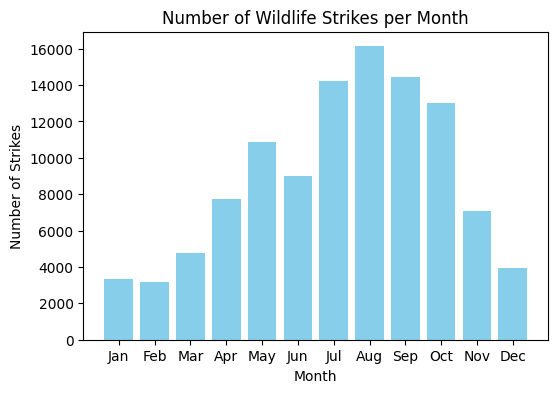

In [15]:
# Visualise number of strikes throughout the year (across months)
data_month = data.groupby('INCIDENT_MONTH').size().reset_index(name='STRIKE_COUNT')

plt.figure(figsize=(6,4))
plt.bar(data_month['INCIDENT_MONTH'], data_month['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes per Month')
plt.xticks(data_month['INCIDENT_MONTH'], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

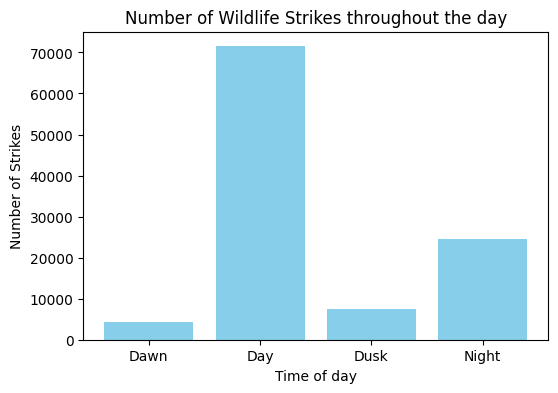

In [16]:
# Group by time of day and count the number of strikes
time_strikes = data.groupby('TIME_OF_DAY').size().reset_index(name='STRIKE_COUNT')

# Plot the data
plt.figure(figsize=(6,4))
plt.bar(time_strikes['TIME_OF_DAY'], time_strikes['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Time of day')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes throughout the day')
plt.xticks(time_strikes['TIME_OF_DAY'])
plt.show()

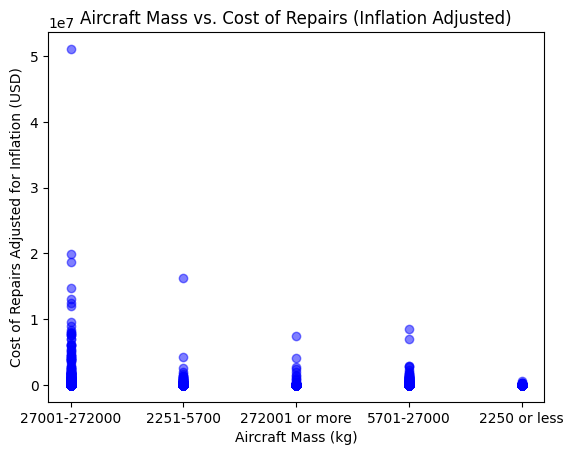

In [17]:
# Scatter plot of aircraft mass against cost of repairs
plt.scatter(data['AC_MASS'],data['COST_REPAIRS_INFL_ADJ'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Aircraft Mass (kg)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Aircraft Mass vs. Cost of Repairs (Inflation Adjusted)')
plt.show()

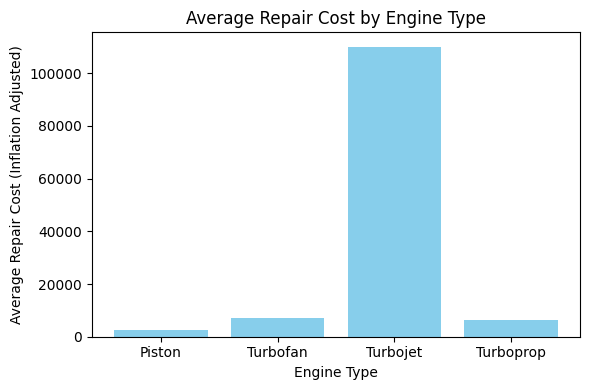

In [18]:
# Visualize the relationship between TYPE_ENG (engine type) and COST_REPAIRS_INFL_ADJ (adjusted repair cost)
eng_cost_summary = data.groupby('TYPE_ENG')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
eng_cost_summary.columns = ['Engine Type', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(eng_cost_summary['Engine Type'], eng_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Type')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Type')
plt.tight_layout()
plt.show()

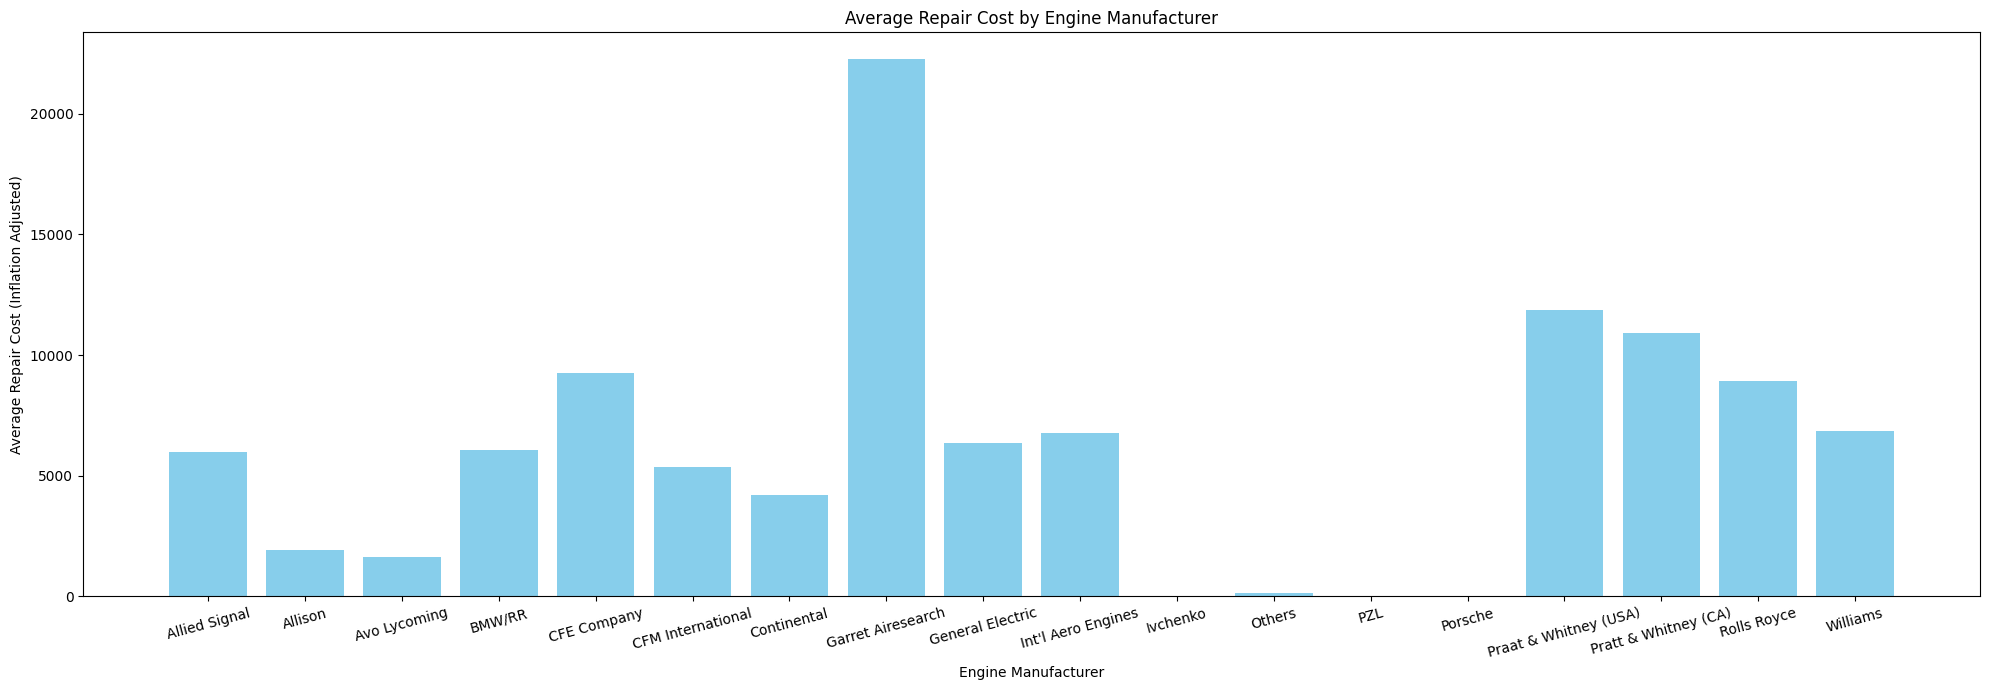

In [19]:
# Visualize the relationship between manufacturer of engine and adjusted repair cost
manu_cost_summary = data.groupby('ENGIN_MANUFACTURER')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
manu_cost_summary.columns = ['Engine Manufacturer', 'Average Repair Cost']

# plot data
plt.figure(figsize=(20, 7))
plt.bar(manu_cost_summary['Engine Manufacturer'], manu_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Manufacturer')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

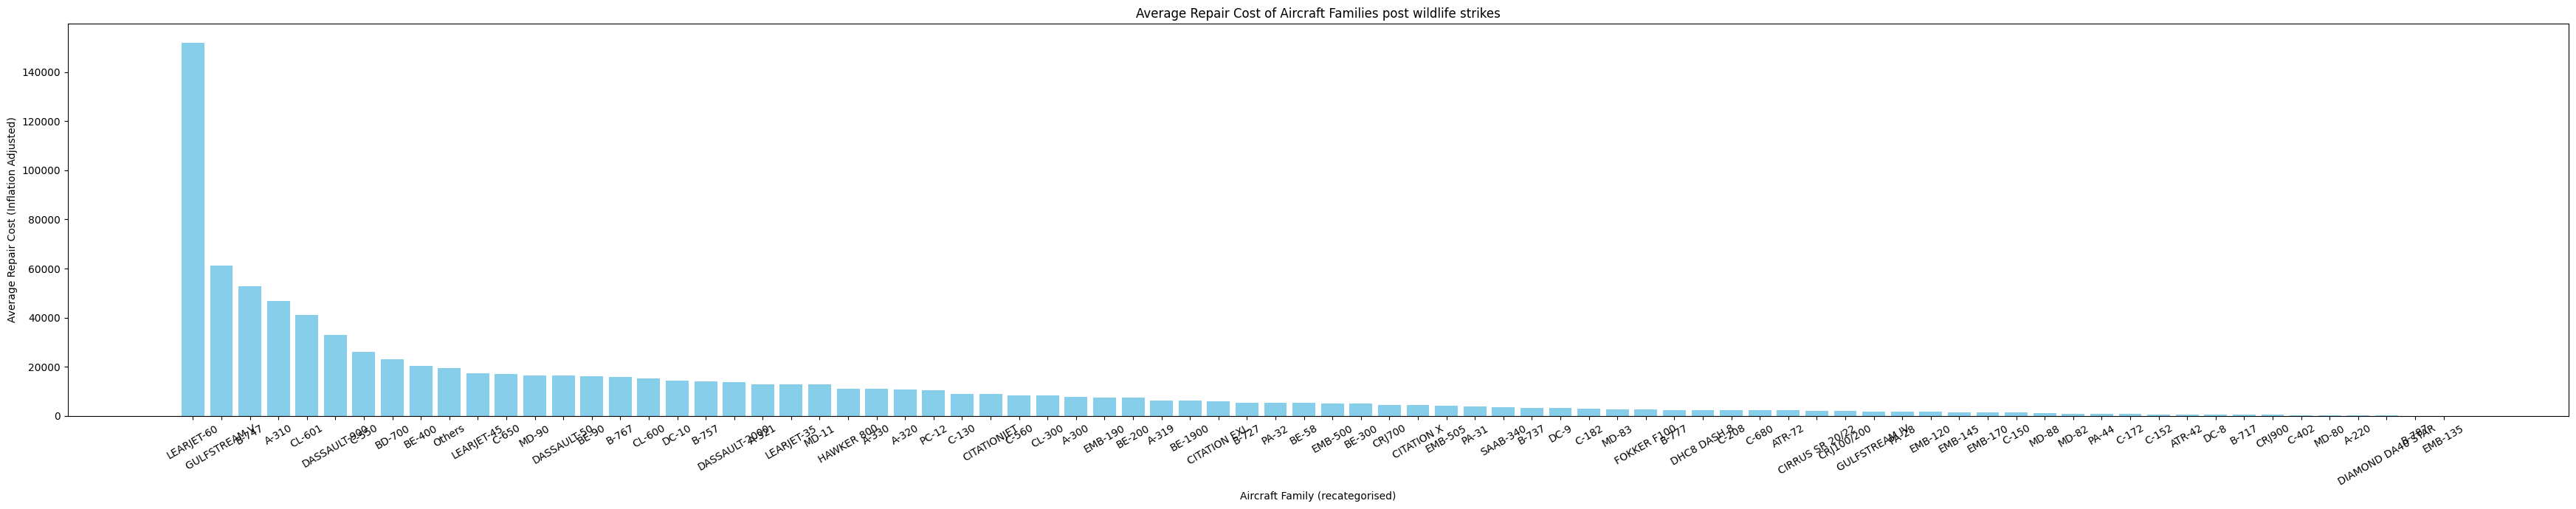

In [20]:
# Visualize the relationship between aircraft family and adjusted repair cost again
aircraft_cost_rev = data.groupby('AIRCRAFT_FAMILY_GROUPED')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
aircraft_cost_rev.columns = ['Aircraft Family revised', 'Average Repair Cost']

# Sort the dataframe by 'Average Repair Cost' in descending order
aircraft_cost_rev = aircraft_cost_rev.sort_values(by='Average Repair Cost', ascending=False)

# Plot data
plt.figure(figsize=(35, 7))
plt.bar(aircraft_cost_rev['Aircraft Family revised'], aircraft_cost_rev['Average Repair Cost'], color='skyblue')
plt.xlabel('Aircraft Family (recategorised)')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost of Aircraft Families post wildlife strikes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

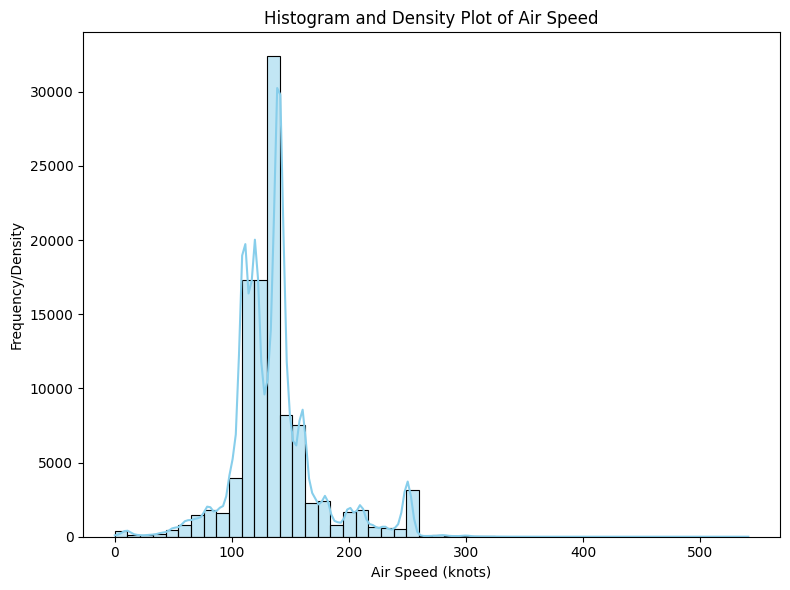

In [21]:
# Speed distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['SPEED'], kde=True, color='skyblue', bins=50)
plt.title('Histogram and Density Plot of Air Speed')
plt.xlabel('Air Speed (knots)')
plt.ylabel('Frequency/Density')
plt.tight_layout()
plt.show()

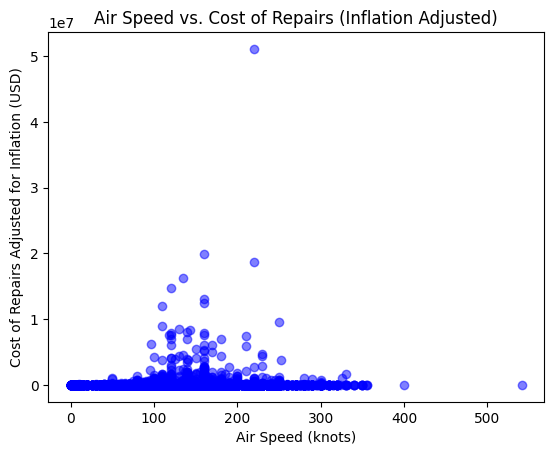

In [23]:
# Scatter plot of aircraft speed against cost of repairs
plt.scatter(data['SPEED'],data['COST_REPAIRS_INFL_ADJ'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Air Speed (knots)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Air Speed vs. Cost of Repairs (Inflation Adjusted)')
plt.show()

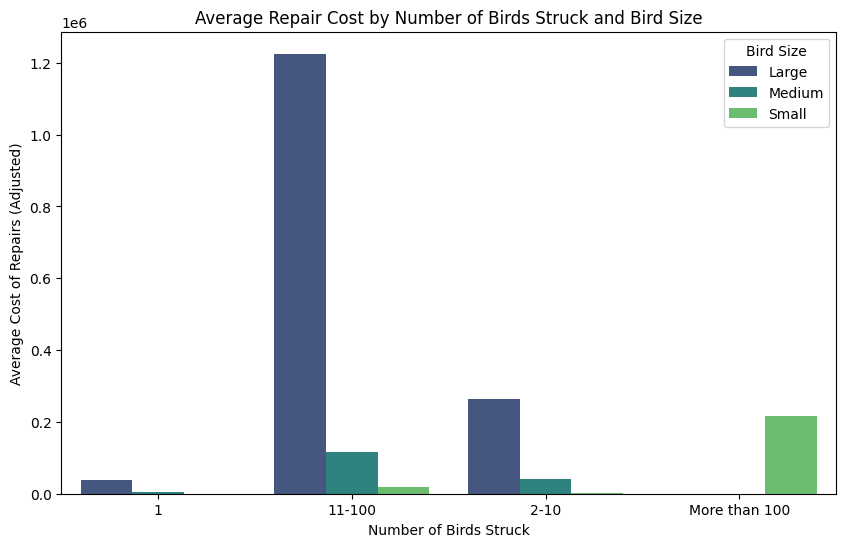

In [24]:
# Visualise relationship between cost and NUM_STRUCK and SIZE
grouped_data = data.groupby(['NUM_STRUCK', 'SIZE'])['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='NUM_STRUCK', y='COST_REPAIRS_INFL_ADJ', hue='SIZE', data=grouped_data, palette='viridis')
plt.xlabel('Number of Birds Struck')
plt.ylabel('Average Cost of Repairs (Adjusted)')
plt.title('Average Repair Cost by Number of Birds Struck and Bird Size')
plt.legend(title='Bird Size')
plt.show()

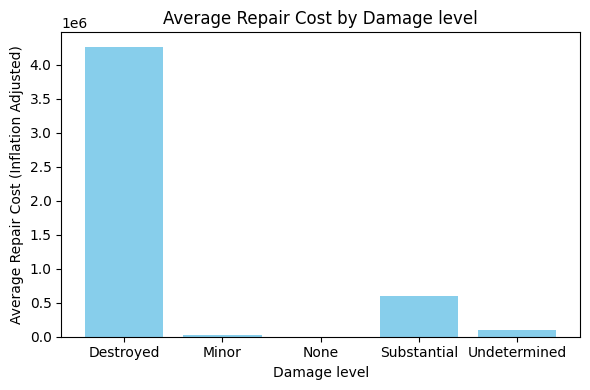

In [25]:
# Visualize the relationship between damage level and adjusted repair cost
damagelev_cost = data.groupby('DAMAGE_LEVEL')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
damagelev_cost.columns = ['Damage level', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(damagelev_cost['Damage level'], damagelev_cost['Average Repair Cost'], color='skyblue')
plt.xlabel('Damage level')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Damage level')
plt.tight_layout()
plt.show()

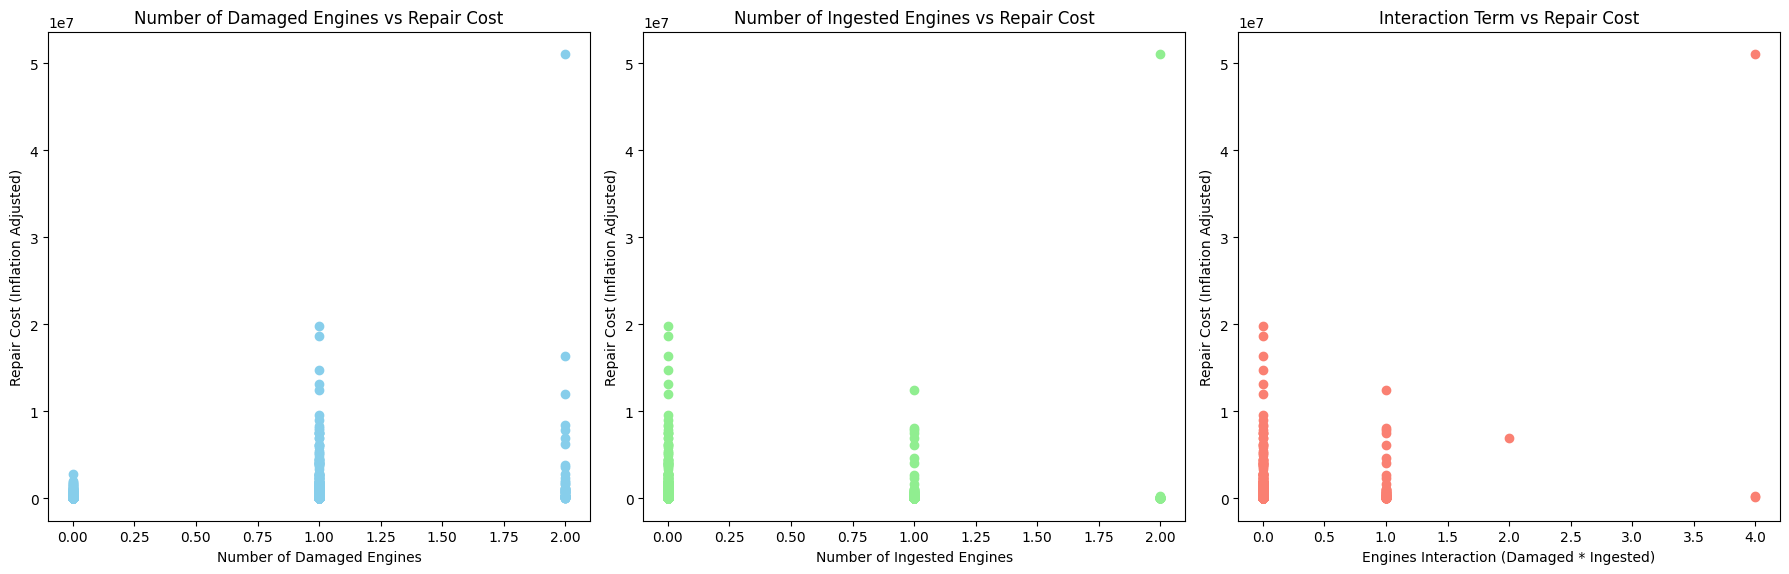

In [26]:
# Visualise the relationship between cost and each of the individual damage/ingested/interaction term variables
# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot NUM_DAM_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[0].scatter(data['NUM_DAM_ENGINES'], data['COST_REPAIRS_INFL_ADJ'], color='skyblue')
axes[0].set_title('Number of Damaged Engines vs Repair Cost')
axes[0].set_xlabel('Number of Damaged Engines')
axes[0].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot NUM_ING_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[1].scatter(data['NUM_ING_ENGINES'], data['COST_REPAIRS_INFL_ADJ'], color='lightgreen')
axes[1].set_title('Number of Ingested Engines vs Repair Cost')
axes[1].set_xlabel('Number of Ingested Engines')
axes[1].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot ENGINES_INTERACTION vs COST_REPAIRS_INFL_ADJ
axes[2].scatter(data['ENGINES_INTERACTION'], data['COST_REPAIRS_INFL_ADJ'], color='salmon')
axes[2].set_title('Interaction Term vs Repair Cost')
axes[2].set_xlabel('Engines Interaction (Damaged * Ingested)')
axes[2].set_ylabel('Repair Cost (Inflation Adjusted)')

plt.tight_layout()
plt.show()

Final processing of the data

In [ ]:
def final_process(df):
    df = df.drop(columns=['COST_REPAIRS_INFL_ADJ', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE'])
    return df

#### Modelling
Considering the dimensionality of the dataset as a result of multiple categorical variables, LASSO regression model was chosen to reduce the dimensionality and for the model to focus on the features that have predictive power on the eventual target ie the repair cost of airplanes.

A few considerations will be tested out step-by-step:
1. The entire final dataset will first be tested at alpha=0.001, then tuned. The tuned model will serve as the base model for comparison across the stages.
2. Considering that damage level is a composite of the damages to the entire aircraft after the wildlife strike, model will be tested without damage level as a variable. Depending on the performance of the model relative to model 1, it may or may not be retained for 3rd execution of the model.
3. Aircraft mass is associated with aircraft family, and considering that aircraft family is a lot more granular when the cost is more highly related to engines, model will be executed without aircraft family for comparison.

In [ ]:
def initial_lasso(df, target_column='log1p_COST_REPAIRS_INFL_ADJ', alpha=0.001, test_size=0.3, random_state=5):
    """
    Function to preprocess data to fit into a Lasso model, and return the Mean Squared Error (MSE).
    
    Returns:
        float: The Mean Squared Error of the model on the test set.
    """
    
    # Construct the feature matrix and target vector
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

    # Define the transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),  # Scale numeric columns
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical columns
        ]
    )

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=alpha))
    ])

    # Separate the data into training and test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit the pipeline on the training data
    pipeline.fit(x_train, y_train)

    # Evaluate the pipeline on the test set
    y_pred = pipeline.predict(x_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [32]:
final_data = final_process(data)
print('MSE of initial LASSO model at alpha=0.001:', initial_lasso(final_data))

MSE of initial LASSO model at alpha=0.001: 0.08533090984404489


#### Finetuning LASSO model for investigation 1

In [34]:
def fine_tune_lasso(df, target_column='log1p_COST_REPAIRS_INFL_ADJ', alpha_range=None, n_iter=20, cv=5, test_size=0.3, random_state=5):
    """
    Fine-tune a Lasso regression model using RandomizedSearchCV and return the best model and its MSE.

    Returns:
        tuple: Best alpha value, final model, and its Mean Squared Error (MSE) on the test set.
    """
    
    # Construct the feature matrix and target vector
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

    # Define the transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),  # Scale numeric columns
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical columns
        ]
    )

    # If no alpha_range is provided, use a default range
    if alpha_range is None:
        alpha_range = np.logspace(-4, 1, 100)

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ])

    # Separate the data into training and test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Set up the RandomizedSearchCV
    param_dist = {'model__alpha': alpha_range}
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                       scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter, random_state=random_state)

    # Fit the RandomizedSearchCV model
    random_search.fit(x_train, y_train)

    # Best parameter
    best_alpha = random_search.best_params_['model__alpha']

    # Get the best model from the random search
    best_model = random_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(x_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    return best_alpha, best_model, mse


In [46]:
# Call the function and unpack the returned values
best_alpha, best_model, mse = fine_tune_lasso(final_data)
print(f"Best alpha: {best_alpha}, Best LASSO model for investigation 1: {best_model}, MSE: {mse}")

Best alpha: 0.00031992671377973844, Best LASSO model for investigation 1: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['INCIDENT_MONTH', 'SPEED',
                                                   'NUM_DAM_ENGINES',
                                                   'NUM_ING_ENGINES',
                                                   'ENGINES_INTERACTION']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TIME_OF_DAY', 'AIRPORT_ID',
                                                   'AC_MASS', 'TYPE_ENG',
                                                   'DAMAGE_LEVEL', 'DAM_RAD',
                                                   'DAM_WINDSHLD', 'DAM_NOSE',
                                                   'INGESTED_OTHER

##### Investigation 2 & finetuning of model

In [36]:
def lasso_invest2(df, target_column='log1p_COST_REPAIRS_INFL_ADJ', alpha_range=None, n_iter=20, cv=5, test_size=0.3, random_state=5):
    """
    Fine-tune a Lasso regression model using RandomizedSearchCV and return the best model and its MSE.

    Returns:
        tuple: Best alpha value, final model, and its Mean Squared Error (MSE) on the test set.
    """
    
    # Construct the feature matrix and target vector
    X = df.drop([target_column, 'DAMAGE_LEVEL'], axis=1)
    y = df[target_column]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

    # Define the transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),  # Scale numeric columns
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical columns
        ]
    )

    # If no alpha_range is provided, use a default range
    if alpha_range is None:
        alpha_range = np.logspace(-4, 1, 100)

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ])

    # Separate the data into training and test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Set up the RandomizedSearchCV
    param_dist = {'model__alpha': alpha_range}
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                       scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter, random_state=random_state)

    # Fit the RandomizedSearchCV model
    random_search.fit(x_train, y_train)

    # Best parameter
    best_alpha = random_search.best_params_['model__alpha']

    # Get the best model from the random search
    best_model = random_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(x_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    return best_alpha, best_model, mse

best_alpha2, best_model2, mse2 = lasso_invest2(final_data)
print(f"Best alpha for investigation 2: {best_alpha2}, Best LASSO model for investigation 2: {best_model2}, MSE: {mse2}")

Best alpha for investigation 2: 0.0004037017258596554, Best LASSO model for investigation 2: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['INCIDENT_MONTH', 'SPEED',
                                                   'NUM_DAM_ENGINES',
                                                   'NUM_ING_ENGINES',
                                                   'ENGINES_INTERACTION']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TIME_OF_DAY', 'AIRPORT_ID',
                                                   'AC_MASS', 'TYPE_ENG',
                                                   'DAM_RAD', 'DAM_WINDSHLD',
                                                   'DAM_NOSE', 'INGESTED_OTHER',
                                             

#### Investigation 3 & finetuning of model

In [37]:
def lasso_invest3(df, target_column='log1p_COST_REPAIRS_INFL_ADJ', alpha_range=None, n_iter=20, cv=5, test_size=0.3, random_state=5):
    """
    Fine-tune a Lasso regression model using RandomizedSearchCV and return the best model and its MSE.

    Returns:
        tuple: Best alpha value, final model, and its Mean Squared Error (MSE) on the test set.
    """
    
    # Construct the feature matrix and target vector
    X = df.drop([target_column, 'AIRCRAFT_FAMILY_GROUPED'], axis=1)
    y = df[target_column]

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

    # Define the transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),  # Scale numeric columns
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Encode categorical columns
        ]
    )

    # If no alpha_range is provided, use a default range
    if alpha_range is None:
        alpha_range = np.logspace(-4, 1, 100)

    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ])

    # Separate the data into training and test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Set up the RandomizedSearchCV
    param_dist = {'model__alpha': alpha_range}
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                       scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter, random_state=random_state)

    # Fit the RandomizedSearchCV model
    random_search.fit(x_train, y_train)

    # Best parameter
    best_alpha = random_search.best_params_['model__alpha']

    # Get the best model from the random search
    best_model = random_search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(x_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)

    return best_alpha, best_model, mse

best_alpha3, best_model3, mse3 = lasso_invest3(final_data)
print(f"Best alpha for investigation 3: {best_alpha3}, Best LASSO model for investigation 3: {best_model3}, MSE: {mse3}")

Best alpha for investigation 3: 0.00031992671377973844, Best LASSO model for investigation 3: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['INCIDENT_MONTH', 'SPEED',
                                                   'NUM_DAM_ENGINES',
                                                   'NUM_ING_ENGINES',
                                                   'ENGINES_INTERACTION']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TIME_OF_DAY', 'AIRPORT_ID',
                                                   'AC_MASS', 'TYPE_ENG',
                                                   'DAMAGE_LEVEL', 'DAM_RAD',
                                                   'DAM_WINDSHLD', 'DAM_NOSE',
                                              

#### Comparison of models

In [ ]:
def compare_models(models_and_mses, mse_threshold=0.01):
    """
    Compare multiple Lasso models based on their MSE and the number of selected features.
    Includes MSE difference comparison.

    Returns:
        str: Summary of the best-performing model and whether the additional feature should be included.
    """
    # Sort models by their MSE (lower is better)
    sorted_models = sorted(models_and_mses, key=lambda x: x[1])
    
    # Extract top two models
    top_model, second_model = sorted_models[0], sorted_models[1]
    
    # Extract coefficients from the top two models
    coef1 = top_model[0].named_steps['model'].coef_
    coef2 = second_model[0].named_steps['model'].coef_
    
    # Count non-zero coefficients for each model
    num_features1 = np.sum(coef1 != 0)
    num_features2 = np.sum(coef2 != 0)
    
    # Calculate the MSE difference
    mse_difference = abs(top_model[1] - second_model[1])
    
    # Compare MSE and feature counts
    result = (
        f"Model 1: MSE = {top_model[1]}, Selected Features = {num_features1}\n"
        f"Model 2: MSE = {second_model[1]}, Selected Features = {num_features2}\n"
        f"MSE Difference: {mse_difference}\n"
    )
    
    # Decision logic based on MSE difference and feature counts
    if mse_difference <= mse_threshold:
        result += (
            "Conclusion: Both models have similar performance (MSE difference within the threshold). "
            "Choose the model with fewer features for simplicity."
        )
        if num_features1 <= num_features2:
            result += " Best model is Model 1."
        else:
            result += " Best model is Model 2."
    else:
        if num_features2 < num_features1:
            result += "Conclusion: Additional features should not be considered, and the best model is chosen."
        else:
            result += "Conclusion: Additional features should be considered, and the second-best model is preferred."
    
    alpha = best_alpha if num_features2 >= num_features1 else best_alpha2
    result += f"\nAlpha value for the best model: {alpha}"

    return result

models = [best_model, best_model2, best_model3]  # List of all models
mses = [mse, mse2, mse3]                        # Corresponding list of MSEs
models_and_mses = list(zip(models, mses))
print(compare_models(models_and_mses, mse_threshold=0.01))

Model 1: MSE = 0.0838930980604949, Selected Features = 39
Model 2: MSE = 0.08390054463949918, Selected Features = 36
MSE Difference: 7.446579004283249e-06
Conclusion: Both models have similar performance (MSE difference within the threshold). Choose the model with fewer features for simplicity. Best model is Model 2.
Alpha value for the best model: 0.0004037017258596554


Model 2 above corresponds to the model obtained from investigation 3. Based on the MSE score as well as the number of features, it can be concluded that aircraft family may not be critical in the prediction of repair costs of airplanes. In addition, the number of features from investigation from model 3 is also less than that in model 1, which facilitates better understanding and more targetted focus on the factors contributing to repair costs. 

However, further investigation will still be necessary to better understanding the causal relationships between these factors and the target - cost.

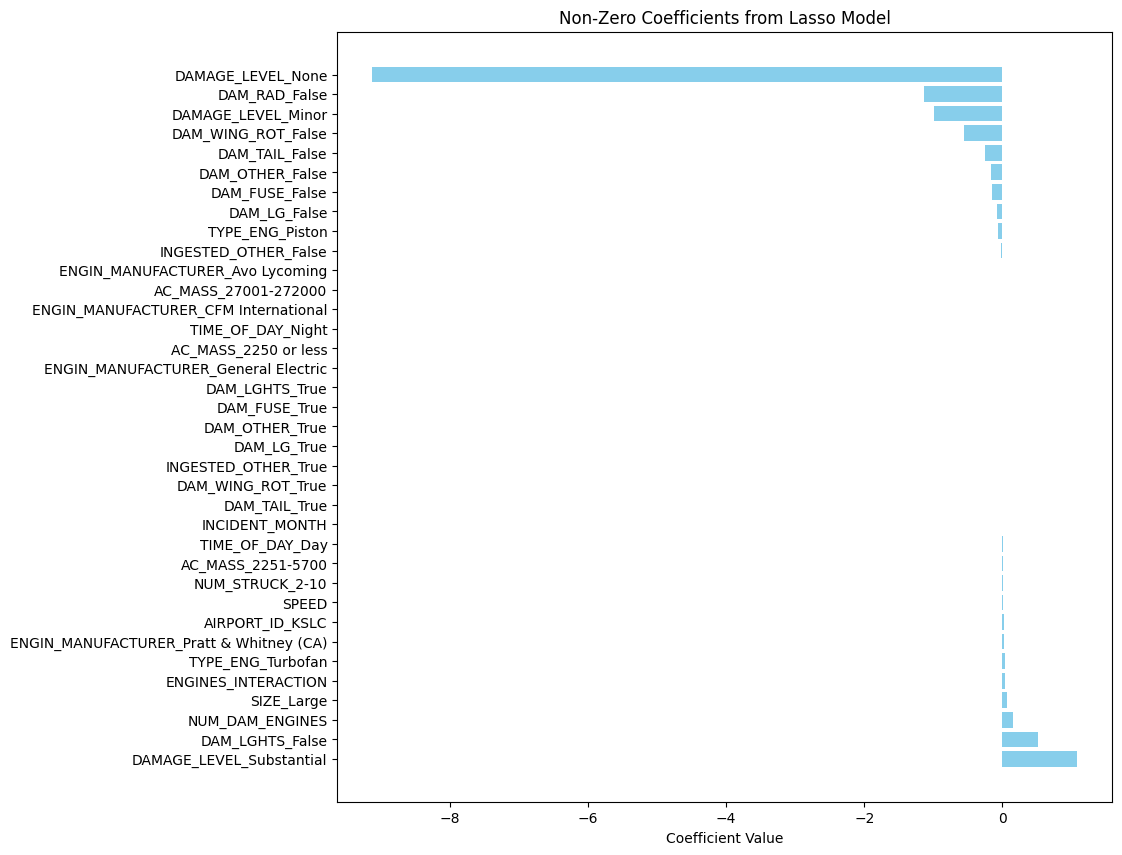

In [49]:
def plot_nonzero_coefficients(model, feature_names):
    """
    Plot the non-zero coefficients from the Lasso model.

    Returns:
        None: It will display a bar plot of non-zero coefficients.
    """
    # Access the Lasso model's coefficients
    lasso_coefficients = model.named_steps['model'].coef_

    # Get non-zero coefficient indices
    nonzero_indices = np.where(lasso_coefficients != 0)[0]

    # Extract transformed feature names from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    encoded_feature_names = []

    # Handle numeric features
    numeric_features = preprocessor.transformers_[0][2]

    # Handle categorical features (after one-hot encoding)
    onehot_encoder = preprocessor.transformers_[1][1]
    categorical_features = preprocessor.transformers_[1][2]
    onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

    # Combine all feature names in the correct order
    encoded_feature_names.extend(numeric_features)
    encoded_feature_names.extend(onehot_feature_names)

    # Map non-zero coefficients to their feature names and coefficients
    nonzero_features = [encoded_feature_names[i] for i in nonzero_indices]
    nonzero_coeffs = lasso_coefficients[nonzero_indices]

    # Sort features and coefficients in decreasing order of coefficient value
    sorted_indices = np.argsort(nonzero_coeffs)[::-1]  # Sort in descending order
    nonzero_coeffs_sorted = nonzero_coeffs[sorted_indices]
    nonzero_features_sorted = np.array(nonzero_features)[sorted_indices]

    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.barh(nonzero_features_sorted, nonzero_coeffs_sorted, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title('Non-Zero Coefficients from Lasso Model')
    plt.show()

# Get feature names before preprocessing
original_feature_names = final_data.drop(['log1p_COST_REPAIRS_INFL_ADJ', 'AIRCRAFT_FAMILY_GROUPED'], axis=1).columns.tolist()

# Plot non-zero coefficients from the model
plot_nonzero_coefficients(best_model3, original_feature_names)

#### Model deployment

In [50]:
import pickle

# Save the final model (best_model3) to a file
with open('final_model.pkl', 'wb') as file:
    pickle.dump(best_model3, file)

In [54]:
def load_and_evaluate_model(keep_cols=cols_to_keep, model_file_path='final_model.pkl'):
    """
    Load the test data, preprocess it, and evaluate the model's performance on the test data.

    Parameters:
    - keep_cols (list): List of columns to keep from the loaded data.
    - model_file_path (str): Path to the saved model file (default is 'final_model.pkl').

    Returns:
    - float: MSE (Mean Squared Error) of the model on the test data.
    """
    # Prompt for the test file path
    test_file_path = input("Enter the path to your test file: ")

    try:
        # Load the test data from the provided file path
        test_data = pd.read_csv(test_file_path)
        print("Data successfully loaded.")

        # Keep the necessary columns from the loaded data
        test_data = test_data[keep_cols]

        # Apply initial preprocessing and final processing
        test_data = initial_preprocess(test_data)
        test_data = final_process(test_data)

        # Separate features (X) and target (y) from the test data
        X_test = test_data.drop(['log1p_COST_REPAIRS_INFL_ADJ', 'AIRCRAFT_FAMILY_GROUPED'], axis=1)
        y_test = test_data['log1p_COST_REPAIRS_INFL_ADJ']

        # Load the saved model from the file
        with open(model_file_path, 'rb') as file:
            loaded_model = pickle.load(file)
        print(f"Model loaded from '{model_file_path}'")

        # Use the loaded model to make predictions on the test set
        y_pred_loaded = loaded_model.predict(X_test)

        # Calculate the MSE with the loaded model
        mse_loaded = mean_squared_error(y_test, y_pred_loaded)
        print(f"MSE of loaded model: {mse_loaded}")

        return mse_loaded

    except Exception as e:
        print(f"Error: {e}")
        return None

print('MSE of test set:', load_and_evaluate_model())

Error: [Errno 2] No such file or directory: ''
MSE of test set: None
